1. Importare dependente si date

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [ ]:
import tensorflow as tf

# Limitare RAM folosit
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Importare date: 'fashion_mnist' - date de antrenare 
dataset = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7834BR/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7834BR/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

2. Vizualizare date si construire pipeline

In [ ]:
import numpy as np

In [ ]:
# Iterator
data_iterator = dataset.as_numpy_iterator()

In [ ]:
# Obtinere date din pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

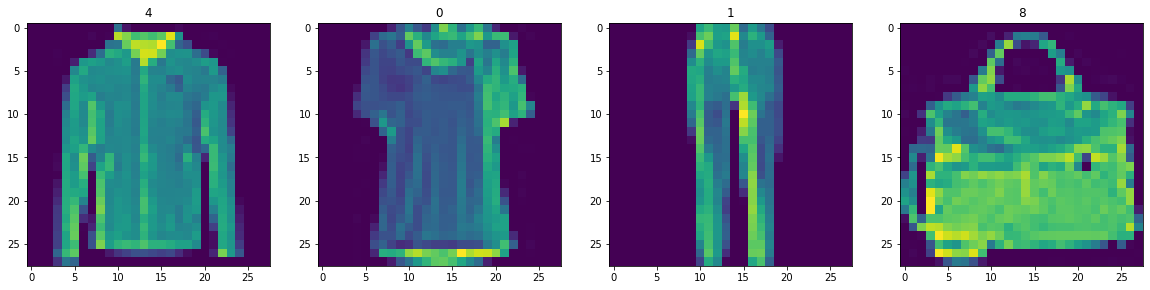

In [ ]:
# Setare format subplot si vizualizare 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  sample = data_iterator.next()
  ax[idx].imshow(np.squeeze(sample['image'])) # 28x28
  ax[idx].title.set_text(sample['label'])

In [ ]:
# Scalare imagini
def scale_images(data):
  image = data['image']
  return image / 255

In [ ]:
# Map, cache, shuffle, batch, prefetch
dataset = tfds.load('fashion_mnist', split='train')

# Trecere dataset prin pasul de preprocesare scale_images
dataset = dataset.map(scale_images)
# Cache dataset pentru batch-ul respectiv
dataset = dataset.cache()
dataset = dataset.shuffle(60000)
dataset = dataset.batch(128)
# Prefetch - reduce riscul de bottlenecking
dataset = dataset.prefetch(64)

In [ ]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

3. Retele neuronale

In [ ]:
from tensorflow import keras
# Sequential API pentru Generator si Discriminator
from keras.models import Sequential
# Straturi retea neuronala
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D 
# convoluții, strat FC, reducere a dimensionalității, redimensionare, funcție de activare, regularizare, upsampling (pt. generator)

In [ ]:
from keras.layers.convolutional.base_depthwise_conv import Conv

# Construire GENERATOR

def build_generator():
  model = Sequential() # Instanțiere model

  # Primire 128 valori aleatoare si remodelare
  model.add(Dense(7*7*128, input_dim=128)) # input layer: FC layer, 7*7*128 unitati
  model.add(LeakyReLU(0.2)) # funcție de activare (pentru neliniaritați)
  model.add(Reshape((7,7,128))) # 7x7x128

  # Bloc upsampling nr. 1
  model.add(UpSampling2D()) # 14x14x128
  model.add(Conv2D(128, 5, padding='same')) # 128 unitati, 128 filtre (kernels) de dim. 5x5
  model.add(LeakyReLU(0.2))

  # Bloc upsampling nr. 2
  model.add(UpSampling2D()) # 28x28x128
  model.add(Conv2D(128, 5, padding='same')) 
  model.add(LeakyReLU(0.2))

  # Bloc convolutional nr. 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Bloc convolutional nr. 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer ca sa ajungem la 1 canal
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid')) # 28x28x1
                                                                # functie de activare sigmoid => valori intre 0 si 1

  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 56.2 MB/s eta 0:00:00


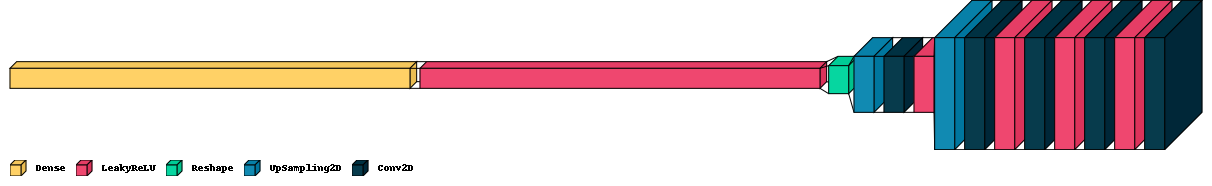

In [ ]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(generator, legend=True)

1/1 [==============================] - 7s 7s/step


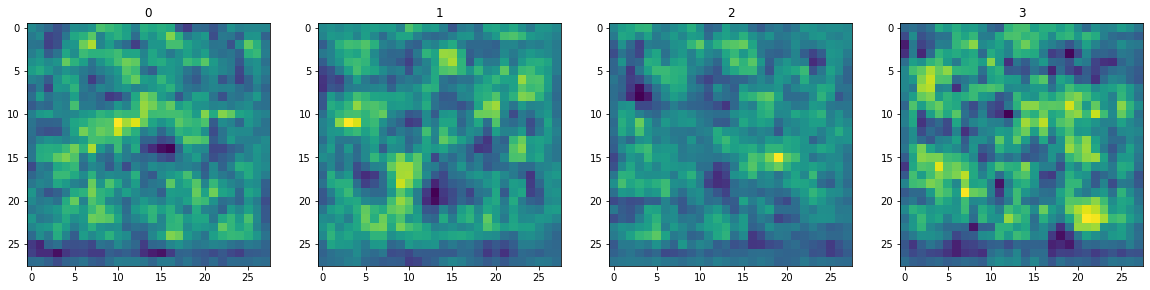

In [ ]:
# Generare de noi imagini cu articole vestimentare
img = generator.predict(np.random.randn(4, 128, 1)) # genereaza 4 imagini plecand de la 128 valori aleatoare

# Setare format subplot si vizualizare 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [ ]:
from keras.layers.serialization import regularization
# Construire DISCRIMINATOR
def build_discriminator():
  model = Sequential()

  # Bloc convolutional nr. 1 
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1))) # 32 filtre de dim. 5x5, format input 28x28x1
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4)) # regularizare

  # Bloc convolutional nr. 2 
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Bloc convolutional nr. 3 
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Bloc convolutional nr. 4 
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten si trecere printr-un Dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid')) # FC layer, output intre 0 si 1
  
  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

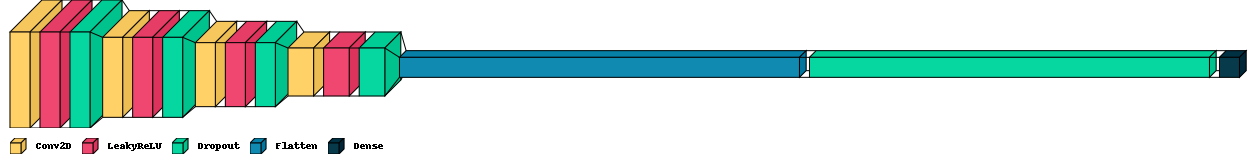

In [ ]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(discriminator, legend=True)

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 142ms/step


array([[0.49533626]], dtype=float32)

4. Construire bucla de antrenare

In [ ]:
# Setare functii cost si optimizatori
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) # pt. generator: optimizator Adam, rata de invatare 0.0001
d_opt = Adam(learning_rate=0.00001) # pt. discriminator: optimizator Adam, rata de invatare 0.00001
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
# Importare base model class (pasul nostru de antrenare va fi subclasa)
from keras.models import Model # base class (clasa de baza)

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # Transmitere args si kwargs catre clasa de baza
    super().__init__(*args, **kwargs)

    # Creare atribute pentru generator si discriminator
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # Compilare cu clasa de baza
    super().compile(*args, **kwargs)

    #Creare atribute pentru optimizatori si functii cost
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    
  def train_step(self, batch): # batch = 128 imagini de dim 28x28x1
    # Obtinere date
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Antrenare discriminator
    with tf.GradientTape() as d_tape: # monitorizarea functiilor pentru a calcula gradientul

      # Transmitere imagini reale si generate (fake) catre discriminator
      ypred_real = self.discriminator(real_images, training=True)
      ypred_fake = self.discriminator(fake_images, training=True)
      ypred_realfake = tf.concat([ypred_real, ypred_fake], axis=0) # predictiile discriminatorului

      # Creare labels (etichete) pentru imagini reale si fake
      y_realfake = tf.concat([tf.zeros_like(ypred_real), tf.ones_like(ypred_fake)], axis=0) # etichete

      # Adaugare zgomot
      noise_real = 0.15 * tf.random.uniform(tf.shape(ypred_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(ypred_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculare loss - BinaryCrossentropy
      total_d_loss = self.d_loss(y_realfake, ypred_realfake)

    # Backpropagation (invatare)
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) # calcul gradient in functie de loss, clacul gradient pt. fiecare variabila antrenabila
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) # aplicare backpropagation in fctie de gradientul pt. fiecare variabila, folosind rata de invatare


    # Antrenare generator
    with tf.GradientTape() as g_tape:

      # Generare imagini noi
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Creare etichete prezise
      predicted_labels = self.discriminator(gen_images, training=False) # trecere imagini generate prin discriminator; discriminatorul nu invata in timp ce antrenam generatorul

      # Calculare loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) # recompensare generator in cazul in care discriminatorul considera o imagine generata ca fiind reala

    # Aplicare backpropagation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables) # calculare gradient
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables)) # aplicare gradient

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Creare instanta a modelului care este subclasa
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compilare model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
import os
from keras.utils import array_to_img
from keras.callbacks import Callback

In [ ]:
!mkdir images

In [ ]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128): # nr. imagini pe care vrem sa le generam, dimensiune latenta
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1)) # generare valori aleatoare
    generated_images = self.model.generator(random_latent_vectors) # trecere valori aleatoare prin generator
    generated_images *= 255 # generare imagini
    generated_images.numpy() # conversie (in numpy array)
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png')) # salvare imagini

In [ ]:
# ANTRENARE 
hist = fashgan.fit(dataset, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50
469/469 [==============================] - 72s 145ms/step - d_loss: 0.5439 - g_loss: 1.0147
Epoch 2/50
469/469 [==============================] - 68s 145ms/step - d_loss: 0.6952 - g_loss: 0.7746
Epoch 3/50
469/469 [==============================] - 69s 147ms/step - d_loss: 0.6971 - g_loss: 0.6711
Epoch 4/50
469/469 [==============================] - 69s 146ms/step - d_loss: 0.6905 - g_loss: 0.6914
Epoch 5/50
469/469 [==============================] - 69s 146ms/step - d_loss: 0.6868 - g_loss: 0.6944
Epoch 6/50
469/469 [==============================] - 69s 146ms/step - d_loss: 0.6938 - g_loss: 0.6603
Epoch 7/50
469/469 [==============================] - 69s 146ms/step - d_loss: 0.6918 - g_loss: 0.6737
Epoch 8/50
469/469 [==============================] - 69s 147ms/step - d_loss: 0.6929 - g_loss: 0.6668
Epoch 9/50
469/469 [==============================] - 68s 146ms/step - d_loss: 0.6900 - g_loss: 0.6579
Epoch 10/50
469/469 [==============================] - 69s 147ms/step - d

In [ ]:
# Analiza performantei
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

5. Testare generator

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1))) # genereaza 16 imagini

1/1 [==============================] - 0s 175ms/step


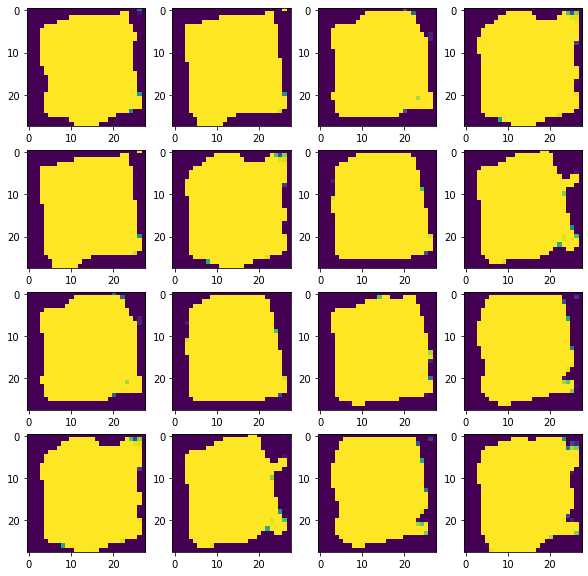

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(np.squeeze(imgs[(r+1)*(c+1)-1]))

In [ ]:
# Salvare model
generator.save('generator_50e.h5')
discriminator.save('discriminator_50e.h5')